In [511]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer

In [512]:
cwd = os.getcwd()
# load data
fpath = "./data/raw/0_Combined_Team_Per90.csv"
if os.path.isfile(fpath) == False:
    print('Error - fpath is invalid')
else:
    df = pd.read_csv(fpath)

In [513]:
# create df for cluster assignment
prep_df = df.drop(columns=["Unnamed: 0", "Season", "TeamID", "League", "Squad", "90s", "# Pl", "# Pl"])

In [514]:
# transform and standardize variables
km_df = PowerTransformer().fit_transform(prep_df)

# fit PCA; want > 90% explained variance
pca_orig = PCA().fit(km_df)
print("Explained variance: ", pca_orig.explained_variance_ratio_[:33].sum())
km_df = PCA(33).fit_transform(km_df)

Explained variance:  0.9007612254424873


/Users/agushansky/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/agushansky/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/agushansky/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


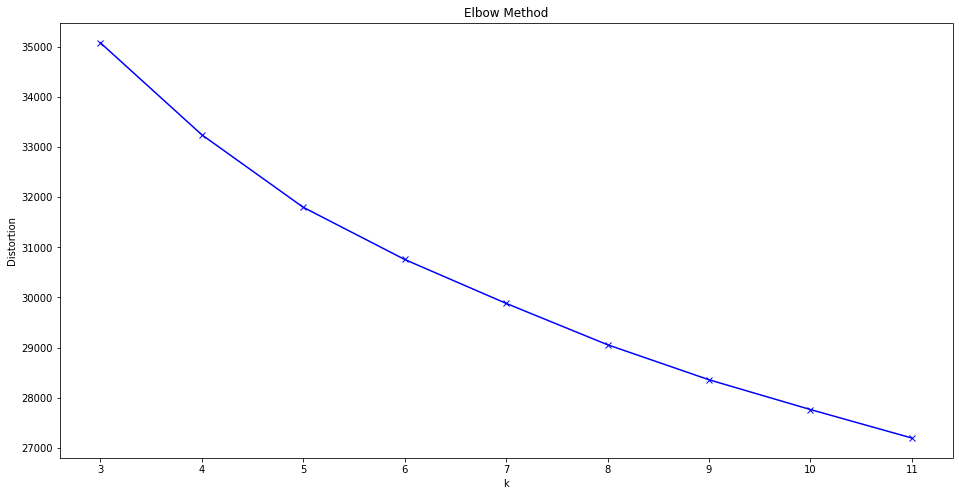

In [515]:
# run kmeans; select select k=7 
# elbow chart adapted from https://predictivehacks.com/k-means-elbow-method-code-for-python/

distortions = []
K = range(3,12)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(km_df)
    distortions.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [516]:
# fit final kmeans
kmeans = KMeans(6).fit(km_df)

# add cluster assignments to df, and create a separate df to plot cluster results
km_labels = pd.DataFrame(kmeans.labels_, columns=["team_play_style"]).squeeze()
plot_kmeans_df = pd.concat([pd.DataFrame(km_df), km_labels, df.Squad, df.Season, df.League], axis=1)
plot_kmeans_df['squad_season'] = plot_kmeans_df['Squad'].str.cat(plot_kmeans_df['Season'].str[-2:], sep="_")

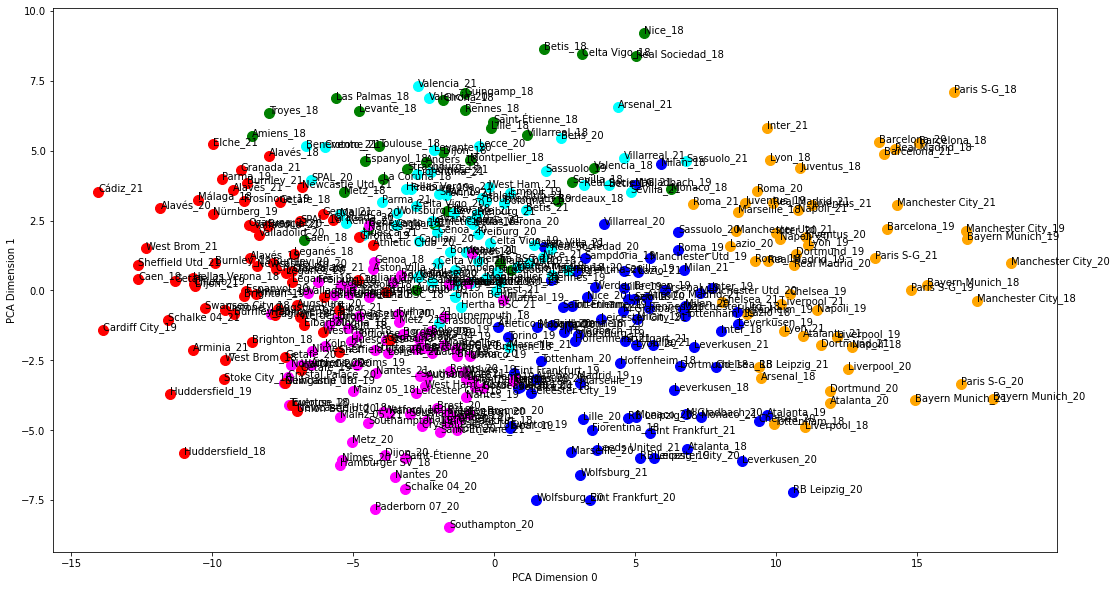

In [517]:
# plot clusters

plt.figure(figsize=(18, 10))

colors = ["orange", "blue", "green", "cyan", "magenta", "red", "yellow", "purple"] # add more colors as K increases

for k in range(km_labels.max()+1):
    X = plot_kmeans_df[plot_kmeans_df.team_play_style == k][0].to_list()
    y = plot_kmeans_df[plot_kmeans_df.team_play_style == k][1].to_list()
    plt.scatter(X, y, s=100, c=colors[k])
    plt.xlabel("PCA Dimension 0")
    plt.ylabel("PCA Dimension 1")
    annotations = plot_kmeans_df[plot_kmeans_df.team_play_style == k]["squad_season"].tolist()
    for i, label in enumerate(annotations):
        plt.annotate(label, (X[i], y[i]))

In [518]:
# one-hot-encode cluster assignments
#team_play_style = pd.get_dummies(km_labels, prefix='team_play_style')

In [519]:
# get average by metric for each cluster 
prep_df = pd.concat([prep_df, km_labels], axis=1)
prep_df = prep_df.groupby("team_play_style").mean()
prep_df.head(10)

,Gls,Sh_x,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,SCA,SCA90,PassLive,PassDead,Drib,Sh_y,Fld_x,Def,GCA,GCA90,PassLive.1,PassDead.1,Drib.1,Sh.1,Fld.1,Def.1,Total Cmp,Total Att,Total Cmp%,Total TotDist,Total PrgDist,Short Cmp,Short Att,Short Cmp%,Medium Cmp,Medium Att,Medium Cmp%,Long Cmp,Long Att,Long Cmp%,Ast,xA,A-xA,KP,1/3_x,PPA,CrsPA,Prog_x,Att_x,Pass Types: Live,Pass Types: Dead,Pass Types: FK,Pass Types: TB,Pass Types: Press,Pass Types: Sw,Pass Types: Crs,Pass Types: CK,Corner Kicks: In,Corner Kicks: Out,Corner Kicks: Str,Height: Ground,Height: Low,Height: High,Body Parts: Left,Body Parts: Right,Body Parts: Head,Body Parts: TI,Body Parts: Other,Outcomes: Cmp,Outcomes: Off,Outcomes: Out,Outcomes: Int,Outcomes: Blocks,Tackles: Tkl,Tackles: TklW,Tackles: Def 3rd,Tackles: Mid 3rd,Tackles: Att 3rd,Vs Dribbles: Tkl,Vs Dribbles: Att,Vs Dribbles: Tkl%,Vs Dribbles: Past,Pressures: Press,Pressures: Succ,Pressures: %,Pressures: Def 3rd,Pressures: Mid 3rd,Pressures: Att 3rd,Blocks: Blocks,Blocks: Sh,Blocks: ShSv,Blocks: Pass,Int_x,Tkl+Int,Clr,Err,Poss,Touches,Def Pen,Def 3rd,Mid 3rd,Att 3rd,Att Pen,Live,Succ,Att_y,Succ%,#Pl,Megs,Carries,TotDist,PrgDist,Prog_y,1/3_y,CPA,Mis,Dis,Targ,Rec,Rec%,Prog.1,CrdY,CrdR,2CrdY,Fls,Fld_y,Off,Crs,Int_y,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Age,MP,Min,Mn/MP,Min%,Starts,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,onxG,onxGA,xG+/-,xG+/-90
team_play_style,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.141481,15.950556,5.838889,36.696296,15.950556,5.838889,0.124815,0.335741,16.772222,0.696667,0.176111,0.217222,1.939259,1.777407,0.113889,0.201111,0.188333,26.300370,26.300370,19.719630,1.806296,1.661481,1.305926,1.315926,0.491296,3.632593,3.632593,2.632593,0.170741,0.267593,0.253889,0.243519,0.067593,545.078148,638.193519,85.251852,10316.476852,3124.321481,228.052037,251.694074,90.407407,235.533519,261.930741,89.814815,72.931667,104.701111,69.668519,1.522593,1.367778,0.190556,12.039444,42.392037,11.921296,2.332037,45.197593,638.193519,593.404815,44.787222,12.060556,1.664259,87.616296,17.589815,13.701852,6.070556,1.466481,1.634259,0.364444,475.040370,74.610000,88.543519,190.658704,395.017778,18.081852,18.964259,7.435185,545.078148,1.827593,7.913889,10.950370,12.792778,16.157407,10.433889,7.040000,6.625741,2.491481,5.342407,15.424444,34.624074,10.082037,143.270185,43.388704,30.355556,40.775185,64.309815,38.185370,13.832222,2.725926,0.066481,11.105370,8.970000,25.127407,17.276481,0.258704,60.285185,749.176111,59.354630,204.219074,381.216296,213.712593,31.833704,705.763889,11.963889,19.390000,61.659259,12.897037,0.745185,531.679259,2696.976481,1487.285741,63.422222,18.553889,5.878333,11.969815,11.277778,613.136852,545.078148,88.809259,49.440556,1.367963,0.063704,0.037963,11.167407,11.480370,2.122407,13.701852,8.970000,10.433889,0.176296,0.130000,0.029815,88.199444,12.442407,11.000741,53.281481,26.811111,37.203704,90.0,90.000000,100.0,11.0,65.037037,2.722407,3.259444,15.833333,5.414259,2.137778,2.207037,1.006296,44.425926,1.200556,1.939259,1.012037,34.279630,0.927593
1,1.601282,13.686795,4.731282,34.642308,13.686795,4.731282,0.106923,0.307564,17.206410,0.515256,0.151923,0.187179,1.519872,1.380256,0.103205,0.081410,0.070128,21.850256,21.850256,15.865897,1.869487,1.413974,1.105513,1.158205,0.435897,2.632821,2.632821,1.804487,0.157308,0.207692,0.212051,0.200769,0.053462,431.915769,534.673718,80.587179,8439.361410,2807.689615,172.385128,196.273590,87.614103,189.061026,217.674487,86.644872,63.546282,102.623462,61.783333,1.125769,1.044744,0.087692,10.140513,32.180256,9.042564,2.323333,37.746667,534.673718,485.328846,49.343846,13.384359,1.108333,81.521667,15.265641,12.675128,5.401282,1.409231,1.548462,0.356282,361.330897,73.377308,99.965256,147.562051,327.052692,20.933077,21.161282,7.322179,431.915769,1.711282,8.862564,9.356923,12.770513,17.921538,1

In [520]:
df = pd.concat([df, km_labels], axis=1)

In [521]:
df.head(10)

,Unnamed: 0,TeamID,Season,League,Squad,# Pl,90s,Gls,Sh_x,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,SCA,SCA90,PassLive,PassDead,Drib,Sh_y,Fld_x,Def,GCA,GCA90,PassLive.1,PassDead.1,Drib.1,Sh.1,Fld.1,Def.1,Total Cmp,Total Att,Total Cmp%,Total TotDist,Total PrgDist,Short Cmp,Short Att,Short Cmp%,Medium Cmp,Medium Att,Medium Cmp%,Long Cmp,Long Att,Long Cmp%,Ast,xA,A-xA,KP,1/3_x,PPA,CrsPA,Prog_x,Att_x,Pass Types: Live,Pass Types: Dead,Pass Types: FK,Pass Types: TB,Pass Types: Press,Pass Types: Sw,Pass Types: Crs,Pass Types: CK,Corner Kicks: In,Corner Kicks: Out,Corner Kicks: Str,Height: Ground,Height: Low,Height: High,Body Parts: Left,Body Parts: Right,Body Parts: Head,Body Parts: TI,Body Parts: Other,Outcomes: Cmp,Outcomes: Off,Outcomes: Out,Outcomes: Int,Outcomes: Blocks,Tackles: Tkl,Tackles: TklW,Tackles: Def 3rd,Tackles: Mid 3rd,Tackles: Att 3rd,Vs Dribbles: Tkl,Vs Dribbles: Att,Vs Dribbles: Tkl%,Vs Dribbles: Past,Pressures: Press,Pressures: Succ,Pressures: %,Pressures: Def 3rd,Pressures: Mid 3rd,Pressures: Att 3rd,Blocks: Blocks,Blocks: Sh,Blocks: ShSv,Blocks: Pass,Int_x,Tkl+Int,Clr,Err,Poss,Touches,Def Pen,Def 3rd,Mid 3rd,Att 3rd,Att Pen,Live,Succ,Att_y,Succ%,#Pl,Megs,Carries,TotDist,PrgDist,Prog_y,1/3_y,CPA,Mis,Dis,Targ,Rec,Rec%,Prog.1,CrdY,CrdR,2CrdY,Fls,Fld_y,Off,Crs,Int_y,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Age,MP,Min,Mn/MP,Min%,Starts,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,onxG,onxGA,xG+/-,xG+/-90,team_play_style
0,0,37745278530914180,2017-2018,La Liga,Alavés,30,38.0,1.05,10.34,3.61,34.9,10.34,3.61,0.10,0.28,18.3,0.58,0.03,0.08,1.02,0.96,0.09,0.03,0.06,15.58,15.58,10.76,1.45,1.00,0.58,1.50,0.29,1.74,1.74,1.29,0.08,0.08,0.13,0.16,0.00,245.95,354.24,69.4,5007.63,2062.79,100.37,125.89,79.7,100.84,131.82,76.5,41.61,85.58,48.6,0.82,0.68,0.13,7.00,21.50,5.08,1.89,23.66,354.24,314.89,39.34,10.84,0.42,72.37,10.92,9.76,3.42,0.05,0.05,0.00,201.50,42.50,110.24,123.45,168.55,31.34,17.05,4.55,245.95,2.37,11.55,7.89,11.05,15.95,10.08,8.82,5.39,1.74,4.95,16.08,30.8,11.13,167.24,40.03,23.9,56.87,79.58,30.79,15.92,3.61,0.03,12.32,9.16,25.11,17.92,0.26,39.8,463.87,56.58,162.16,216.87,111.45,16.82,425.37,9.42,14.53,64.9,10.39,0.61,279.97,1388.74,698.32,26.42,8.47,2.89,11.79,9.74,307.45,245.95,80.0,32.71,2.76,0.11,0.11,16.16,13.97,2.92,9.76,9.16,10.08,0.08,0.26,0.05,92.34,9.89,10.03,49.7,25.5,38,90.0,90,100,11.0,85.0,7.97,2.92,20,4.05,1.24,1.05,1.32,-10,-0.26,1.02,1.40,-14.4,-0.38,5
1,1,37745278530914180,2018-2019,La Liga,Alavés,26,38.0,1.03,11.03,3.11,28.2,11.03,3.11,0.09,0.31,17.7,0.39,0.05,0.08,0.98,0.92,0.08,0.04,0.05,15.53,15.53,9.87,2.03,1.05,0.95,1.24,0.39,1.55,1.55,0.95,0.18,0.08,0.18,0.13,0.03,258.26,366.29,70.5,5355.53,2307.97,103.11,125.11,82.4,102.74,130.50,78.7,47.61,96.71,49.2,0.71,0.63,0.08,7.16,21.87,5.95,2.74,25.29,366.29,314.92,51.37,15.39,0.34,55.68,11.39,13.34,3.82,0.71,0.66,0.13,190.34,56.68,119.26,120.58,177.87,27.21,21.18,4.79,258.26,1.26,10.21,6.66,10.97,16.74,9.61,8.66,6.16,1.92,5.95,17.34,34.3,11.39,154.39,36.47,23.6,51.66,72.50,30.24,15.95,3.05,0.05,12.89,9.03,25.76,30.21,0.21,42.7,489.08,61.34,168.68,232.79,113.55,17.68,438.66,8.45,15.11,55.9,9.03,0.39,270.63,1324.76,722.66,27.24,8.68,1.76,13.47,9.13,333.11,258.26,77.5,35.37,2.66,0.03,0.00,14.50,13.13,1.53,13.34,9.03,9.61,0.05,0.16,0.05,92.42,18.47,18.97,49.3,26.7,38,90.0,90,100,11.0,85.0,0.00,2.97,17,4.03,1.32,1.03,1.32,-11,-0.29,0.98,1.34,-13.7,-0.36,5
2,2,37745278530914180,2019-2020,La Liga,Alavés,32,38.0,0.89,7.87,2.61,33.1,7.87,2.61,0.09,0.28,16.5,0.26,0.16,0.16,0.97,0.86,0.11,-0.08,-0.12,12.24,12.24,7.76,1.89,0.53,0.71,1.05,0.29,1.39,1.39,0.82,0.18,0.03,0.16,0.18,0.03,255.89,361.92,70.7,5448.92,2276.63,100.74,123.55,81.5,102.47,130.53,78.5,47.74,92.87,51.4,0.53,0.62,-0.09,5.79,19.76,4.66,1.32,22.58,361.92,309.24,52.68,14.32,0.66,68.37,12.05,9.82,3.58,1.11,1.34,0.29,180.89,61.79,119.24,113.00,174.42,28.16,23.05,5.34,255.89,1.53,10.74,5.24,10.13,16.13,9.74,7.76,7.08,1.29,5.11,15.26,33.4,10.16,147.61,38.

In [522]:
# strip down df in preparation for writing to csv
df = pd.DataFrame(df, columns=["Squad", "Season", "team_play_style"])

In [524]:
os.getcwd()

'/Users/agushansky/Documents/GitHub/dva_project'

In [528]:
df.to_csv(r'/Users/agushansky/Documents/GitHub/dva_project/data/interim/cluster_assignments.csv')